## Importing required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import datetime as dt
from sklearn.cluster import AgglomerativeClustering

## Reading input files

In [2]:
train = pd.read_csv("train.csv", keep_default_na=False)

In [3]:
test = pd.read_csv("test.csv", keep_default_na=False)

In [4]:
submission = pd.read_csv("submission.csv", keep_default_na=False)

## Analysis of test, train and submission data

In [5]:
print(
    train.shape, test.shape, submission.shape
)

((20580, 6), (12642, 4), (12642, 3))


In [6]:
print(train.dtypes)
print(test.dtypes)
print(submission.dtypes)

Id                  int64
Province_State     object
Country_Region     object
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object
ForecastId         int64
Province_State    object
Country_Region    object
Date              object
dtype: object
ForecastId        int64
ConfirmedCases    int64
Fatalities        int64
dtype: object


In [7]:
train.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,,Afghanistan,2020-01-22,0.0,0.0
1,2,,Afghanistan,2020-01-23,0.0,0.0
2,3,,Afghanistan,2020-01-24,0.0,0.0
3,4,,Afghanistan,2020-01-25,0.0,0.0
4,5,,Afghanistan,2020-01-26,0.0,0.0


In [8]:
test.head(5)

,ForecastId,Province_State,Country_Region,Date
0,1,,Afghanistan,2020-03-19
1,2,,Afghanistan,2020-03-20
2,3,,Afghanistan,2020-03-21
3,4,,Afghanistan,2020-03-22
4,5,,Afghanistan,2020-03-23


In [9]:
submission.head(5)

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Analysis for each attribute of train data

In [10]:
# test the missing type data
def mis_test(attr):
    return  len(attr.unique()), [x for x in attr.unique() if x == float("NaN") or x == ""]

In [11]:
train.shape

(20580, 6)

In [12]:
mis_test(train.Id)

(20580, [])

In [13]:
mis_test(train.Province_State)

(126, [''])

In [14]:
mis_test(train.Country_Region)

(173, [])

In [15]:
mis_test(train.Date)

(70, [])

In [16]:
mis_test(train.ConfirmedCases)

(1536, [])

In [17]:
mis_test(train.Fatalities)

(328, [])

In [18]:
train.describe()

,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


## Test for Province_State vs Country_Region

In [19]:
# check for Country_Region having more than one Province_State have any missing entry or not
country_list = []
df = train.groupby(train.Country_Region).nunique()
for i in df[df.Province_State > 1].index:
    z = [x for x in train[train.Country_Region == i].Province_State.unique() if x == ""]
    k = []
    if z:
        k = train[train.Country_Region == i].Province_State.unique()
        country_list.append(i)
    print(i, z, k)
print(country_list)

('Australia', [], [])
('Canada', [], [])
('China', [], [])
('Denmark', [''], array(['Faroe Islands', 'Greenland', ''], dtype=object))
('France', [''], array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', ''], dtype=object))
('Netherlands', [''], array(['Aruba', 'Curacao', 'Sint Maarten', ''], dtype=object))
('US', [], [])
('United Kingdom', [''], array(['Bermuda', 'Cayman Islands', 'Channel Islands', 'Gibraltar',
       'Isle of Man', 'Montserrat', ''], dtype=object))
['Denmark', 'France', 'Netherlands', 'United Kingdom']


In [20]:
train[train.Country_Region.isin(country_list)].groupby(
    ["Country_Region", "Province_State"]
).count()

Id  Date  ConfirmedCases  Fatalities
Country_Region Province_State                                        
Denmark                          70    70              70          70
               Faroe Islands     70    70              70          70
               Greenland         70    70              70          70
France                           70    70              70          70
               French Guiana     70    70              70          70
               French Polynesia  70    70              70          70
               Guadeloupe        70    70              70          70
               Martinique        70    70              70          70
               Mayotte           70    70              70          70
               New Caledonia     70    70              70          70
               Reunion           70    70              70          70
               Saint Barthelemy  70    70              70          70
               St Martin         70    70              70          70
Netherlands                      70    70              70          70
               Aruba             70    70              70          70
               Curacao           70    70              70          70
               Sint Maarten      70    70              70          70
United Kingdom                   70    70              70          70
               Bermuda           70    70              70          70
               Cayman Islands    70    70              70          70
               Channel Islands   70    70              70          70
               Gibraltar         70    70              70          70
               Isle of Man       70    70              70          70
               Montserrat        70    70              70          70

## Impute missing value of Province_State with Country_Region as missing value represents rest or whole of the Country_Region

In [21]:
train['Province_State'] = train.apply(
    lambda row: row['Country_Region'] if row['Province_State'] == "" else row['Province_State'],
    axis=1
)
test['Province_State'] = test.apply(
    lambda row: row['Country_Region'] if row['Province_State'] == "" else row['Province_State'],
    axis=1
)

In [22]:
# convert date to date time object
train['DateTime'] = pd.to_datetime(train['Date'])
test['DateTime'] = pd.to_datetime(test['Date'])

## Check whether ConfirmedCases and Fatalities are cumulative or not
- verify result with https://www.worldometers.info/coronavirus/country/india/

In [23]:
# Its look like cumulative to India
train[train.Country_Region == "India"].tail(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,DateTime
9440,13461,India,India,2020-03-22,396.0,7.0,2020-03-22
9441,13462,India,India,2020-03-23,499.0,10.0,2020-03-23
9442,13463,India,India,2020-03-24,536.0,10.0,2020-03-24
9443,13464,India,India,2020-03-25,657.0,12.0,2020-03-25
9444,13465,India,India,2020-03-26,727.0,20.0,2020-03-26
9445,13466,India,India,2020-03-27,887.0,20.0,2020-03-27
9446,13467,India,India,2020-03-28,987.0,24.0,2020-03-28
9447,13468,India,India,2020-03-29,1024.0,27.0,2020-03-29
9448,13469,India,India,2020-03-30,1251.0,32.0,2020-03-30
9449,13470,India,India,2020-03-31,1397.0,35.0,2020-03-31


In [24]:
# Get train and test start and end dates
TRAIN_START = train.Date.min()
TEST_START = test.Date.min()
TRAIN_END = train.Date.max()
TEST_END = test.Date.max()
TRAIN_START, TRAIN_END, TEST_START, TEST_END

('2020-01-22', '2020-03-31', '2020-03-19', '2020-04-30')

In [25]:
# IS data is cumulative and how much discripancy in cumulative data
latest_loc = train[train['Date'] == TRAIN_END][['Province_State', 'ConfirmedCases', 'Fatalities']]
max_loc = train.groupby(['Province_State'])[['ConfirmedCases', 'Fatalities']].max().reset_index()
check = pd.merge(latest_loc, max_loc, on='Province_State')
print("%match in ConfirmedCases", np.mean(check.ConfirmedCases_x == check.ConfirmedCases_y))
print("%match in Fatalities", np.mean(check.Fatalities_x == check.Fatalities_y))

('%match in ConfirmedCases', 0.9897959183673469)
('%match in Fatalities', 0.9829931972789115)


In [26]:
# Mismatch in Fatalities
check[check.Fatalities_x != check.Fatalities_y]

,Province_State,ConfirmedCases_x,Fatalities_x,ConfirmedCases_y,Fatalities_y
120,Georgia,110.0,0.0,3929.0,111.0
134,Iceland,1135.0,2.0,1135.0,5.0
145,Kazakhstan,343.0,2.0,343.0,3.0
206,Slovakia,363.0,0.0,363.0,1.0
236,Hawaii,204.0,0.0,204.0,1.0


In [27]:
# Mismatch in ConfirmedCases
check[check.ConfirmedCases_x != check.ConfirmedCases_y]

,Province_State,ConfirmedCases_x,Fatalities_x,ConfirmedCases_y,Fatalities_y
56,Guizhou,146.0,2.0,147.0,2.0
120,Georgia,110.0,0.0,3929.0,111.0
129,Guyana,12.0,2.0,20.0,2.0


## Data look's like to be cumulative by 98% match rate, force data to be cumulative

In [28]:
# Force data to be cumulative and add other relative kpi's like date change, daywise change in confirmed and fatality cases
def custom_grouping(df, column):
    dfs = []
    for loc, df in tqdm(df.groupby(column)):
        df = df.sort_values(by='Date')
        df['Fatalities'] = df['Fatalities'].cummax()
        df['ConfirmedCases'] = df['ConfirmedCases'].cummax()
        df['LogFatalities'] = np.log(df['Fatalities'] + 1)
        df['LogConfirmed'] = np.log(df['ConfirmedCases'] + 1)
        df['LogConfirmedNextDay'] = df['LogConfirmed'].shift(1)
        df['ConfirmedCasesNextDay'] = df['ConfirmedCases'].shift(1)
        df['DateNextDay'] = df['Date'].shift(1)
        df['LogFatalitiesNextDay'] = df['LogFatalities'].shift(1)
        df['FatalitiesNextDay'] = df['Fatalities'].shift(1)
        dfs.append(df)
    return pd.concat(dfs)

def calc_delta(df):
    for col in df.columns:
        if "NextDay" in col:
            df.loc[df[col].isnull(),col] = df[col.replace("NextDay", "")]
    df['LogConfirmedDelta'] = df['LogConfirmed'] - df['LogConfirmedNextDay']
    df['ConfirmedCasesDelta'] = df['ConfirmedCases'] - df['ConfirmedCasesNextDay']
    df['LogFatalitiesDelta'] =  df['LogFatalities'] - df['LogFatalitiesNextDay']
    df['FatalitiesDelta'] = df['Fatalities'] - df['FatalitiesNextDay']
    df['FatalitiesDelta'] = df['Fatalities'] - df['FatalitiesNextDay']
    df['DateDelta'] = (pd.to_datetime(df['Date']) - pd.to_datetime(df['DateNextDay'])).dt.days
    return df

In [29]:
train_new = custom_grouping(train, ["Province_State"])
train_new = calc_delta(train_new)

100%|██████████| 293/293 [00:01<00:00, 186.15it/s]


In [30]:
# check for any missing date
df_test = train_new.groupby(["Province_State", "DateDelta"])[["Id"]].count()
df_test[df_test.Id.isin(range(2,69))]

,,Id
Province_State,DateDelta,


---

# Task 1: Clustering of data

## Analysis of daywise change in ConfirmedCases and Fatalities
- To analyse the growth rate and death rate

In [31]:
train_clust = train_new[train_new.ConfirmedCases > 0]

## Analysis for top 10 Country_Region
- To identify the growth and death rate
- Calculate top 10 contryies having higher cases and deaths
- check mean and median per Country_Region for top 10 countries from new cases and deaths

In [32]:
df2 = train_clust[train_clust.Date == TRAIN_END].groupby(["Country_Region"]).sum()[["ConfirmedCases", "Fatalities"]]
df2["case_rank"] = df2["ConfirmedCases"].rank(method="dense", ascending=False)
df2["fat_rank"] = df2["Fatalities"].rank(method="dense", ascending=False)

In [33]:
df2.sort_values(by=["case_rank", "fat_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Country_Region,,,,
US,188018.0,3871.0,1.0,3.0
Italy,105792.0,12428.0,2.0,1.0
Spain,95923.0,8464.0,3.0,2.0
China,82280.0,3309.0,4.0,5.0
Germany,71808.0,775.0,5.0,9.0
France,52827.0,3532.0,6.0,4.0
Iran,44605.0,2898.0,7.0,6.0
United Kingdom,25471.0,1793.0,8.0,7.0
Switzerland,16605.0,433.0,9.0,11.0


In [34]:
df2.sort_values(by=["fat_rank", "case_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Country_Region,,,,
Italy,105792.0,12428.0,2.0,1.0
Spain,95923.0,8464.0,3.0,2.0
US,188018.0,3871.0,1.0,3.0
France,52827.0,3532.0,6.0,4.0
China,82280.0,3309.0,4.0,5.0
Iran,44605.0,2898.0,7.0,6.0
United Kingdom,25471.0,1793.0,8.0,7.0
Netherlands,12667.0,1040.0,12.0,8.0
Germany,71808.0,775.0,5.0,9.0


In [35]:
df3 = train_clust.set_index("Country_Region")[
    ["Date", "ConfirmedCasesDelta", "FatalitiesDelta", "LogConfirmedDelta", "LogFatalitiesDelta"]
].join(
    df2[df2.case_rank <= 10],
    on="Country_Region",
    how="inner"
)

In [36]:
df3[["ConfirmedCasesDelta", "FatalitiesDelta", "LogConfirmedDelta", "LogFatalitiesDelta"]].groupby("Country_Region").agg(
    ["mean", "median"]
).describe()

ConfirmedCasesDelta             FatalitiesDelta            \
                     mean      median            mean    median   
count           10.000000   10.000000       10.000000  10.00000   
mean           715.941774  178.800000       47.703644   6.95000   
std            624.202652  308.307404       70.013844  18.22765   
min             35.675251    1.000000        1.436927   0.00000   
25%            173.373962    5.500000       10.295224   0.00000   
50%            552.791667   22.750000       11.975427   0.00000   
75%           1094.059799  227.625000       55.172481   4.00000   
max           1734.295082  997.000000      203.737705  58.50000   

      LogConfirmedDelta            LogFatalitiesDelta             
                   mean     median               mean     median  
count         10.000000  10.000000          10.000000  10.000000  
mean           0.227635   0.146332           0.128426   0.061052  
std            0.104330   0.109858           0.072206   0.081881  
min            0.065506   0.000192           0.019521   0.000000  
25%            0.178725   0.096785           0.068061   0.000000  
50%            0.190424   0.119941           0.144147   0.000000  
75%            0.266172   0.190058           0.165160   0.126472  
max            0.452991   0.399697           0.255745   0.201866

# Use Mean as growth and death rate from the above observation
- Mean is more close to centre of min and max values as compared to median

In [37]:
df4 = train_clust.groupby(
    ["Country_Region"]).agg(
    {
        "LogConfirmedDelta": "mean",
        "ConfirmedCasesDelta": "mean",
        "ConfirmedCases": "sum"
    }
)
df5 = train_clust[train_clust.Fatalities > 0].groupby(
    ["Country_Region"]).agg(
    {
        "LogFatalitiesDelta": "mean",
        "FatalitiesDelta": "mean",
        "Fatalities": "sum"
    }
)
data = df4.join(
    df5, "Country_Region"
).fillna(0)
df6 = data.reset_index()

In [38]:
data.head(10)

,LogConfirmedDelta,ConfirmedCases,ConfirmedCasesDelta,Fatalities,FatalitiesDelta,LogFatalitiesDelta
Country_Region,,,,,,
Afghanistan,0.139589,1225.0,4.702703,29.0,0.400000,0.160944
Albania,0.239007,2232.0,10.565217,91.0,0.714286,0.132028
Algeria,0.182641,4828.0,19.888889,324.0,2.200000,0.190333
Andorra,0.197742,2787.0,12.533333,39.0,1.200000,0.256495
Angola,0.173287,48.0,0.583333,6.0,0.666667,0.366204
Antigua and Barbuda,0.109444,61.0,0.368421,0.0,0.000000,0.000000
Argentina,0.240045,6529.0,36.344828,158.0,1.125000,0.138842
Armenia,0.202533,4099.0,17.161290,12.0,0.500000,0.231049
Australia,0.121725,36155.0,12.524725,190.0,0.243243,0.099867


## Standarization of data and identification of number of clusters
- elbow method
- dendograms

In [39]:
# Standarized all the four feature variables
mms = StandardScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [40]:
# Elbow method
Sum_of_squared_distances = []
K = range(1,15, 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

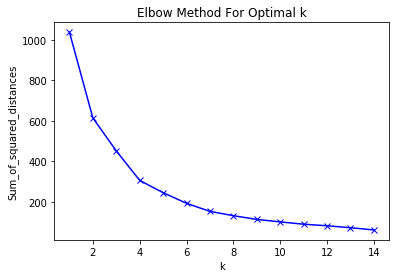

In [41]:
# plot of elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

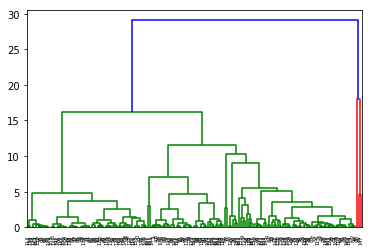

In [42]:
dendrogram = sch.dendrogram(sch.linkage(data_transformed, method='ward'))

## Apply K-means and AgglomerativeClustering with 4 clusters as confirmed by both elbow method and dendograms

In [43]:
kmeans = KMeans(n_clusters=4).fit(data_transformed)
centroids = kmeans.cluster_centers_
# print(centroids)
# print(kmeans.labels_)
df6["kmeans_clusters"] = kmeans.labels_

In [44]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(data_transformed)
df6["heir_clusters"] = model.labels_

In [45]:
df7 = df6.reset_index()[["Country_Region", "kmeans_clusters"]]
df7.groupby("kmeans_clusters")["Country_Region"].apply(list)

kmeans_clusters
0    [Afghanistan, Algeria, Antigua and Barbuda, Au...
1                                              [China]
2                                       [Italy, Spain]
3    [Albania, Andorra, Angola, Argentina, Armenia,...
Name: Country_Region, dtype: object

In [46]:
df7 = df6.reset_index()[["Country_Region", "heir_clusters"]]
df7.groupby("heir_clusters")["Country_Region"].apply(list)

heir_clusters
0    [Albania, Algeria, Andorra, Angola, Argentina,...
1    [Afghanistan, Antigua and Barbuda, Australia, ...
2                                              [China]
3                                       [Italy, Spain]
Name: Country_Region, dtype: object

## reduce features to plot in 2-D using PCA

In [47]:
reduced_data = PCA(n_components=2).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

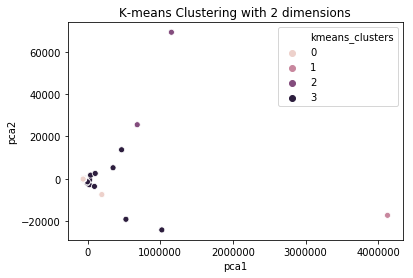

In [48]:
sns.scatterplot(x="pca1", y="pca2", hue=df6['kmeans_clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

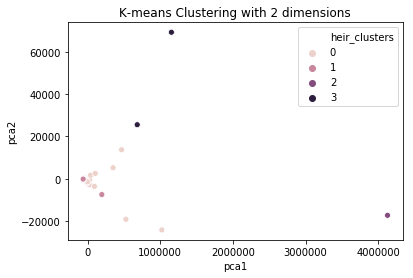

In [49]:
sns.scatterplot(x="pca1", y="pca2", hue=df6['heir_clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## Save cluster result to csv file

In [50]:
df6.to_csv("country_clusters.csv", index=False)

___

# Task 2: Forcast future data

In [51]:
train_new

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,DateTime,LogFatalities,LogConfirmed,LogConfirmedNextDay,ConfirmedCasesNextDay,DateNextDay,LogFatalitiesNextDay,FatalitiesNextDay,LogConfirmedDelta,ConfirmedCasesDelta,LogFatalitiesDelta,FatalitiesDelta,DateDelta
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0,2020-01-22,0.000000,0.000000,0.000000,0.0,2020-01-22,0.000000,0.0,0.000000,0.0,0.000000,0.0,0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0,2020-01-23,0.000000,0.000000,0.000000,0.0,2020-01-22,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0,2020-01-24,0.000000,0.000000,0.000000,0.0,2020-01-23,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0,2020-01-25,0.000000,0.000000,0.000000,0.0,2020-01-24,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0,2020-01-26,0.000000,0.000000,0.000000,0.0,2020-01-25,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
5,6,Afghanistan,Afghanistan,2020-01-27,0.0,0.0,2020-01-27,0.000000,0.000000,0.000000,0.0,2020-01-26,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
6,7,Afghanistan,Afghanistan,2020-01-28,0.0,0.0,2020-01-28,0.000000,0.000000,0.000000,0.0,2020-01-27,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
7,8,Afghanistan,Afghanistan,2020-01-29,0.0,0.0,2020-01-29,0.000000,0.000000,0.000000,0.0,2020-01-28,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
8,9,Afghanistan,Afghanistan,2020-01-30,0.0,0.0,2020-01-30,0.000000,0.000000,0.000000,0.0,2020-01-29,0.000000,0.0,0.000000,0.0,0.000000,0.0,1
9,10,Afghanistan,Afghanistan,2020-01-31,0.0,0.0,2020-01-31,0.000000,0.000000,0.000000,0.0,2020-01-30,0.000000,0.0,0.000000,0.0,0.000000,0.0,1


In [52]:
# model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
# model.fit(data_transformed)
# labels = model.labels_

# plt.scatter(data_transformed[labels==0, 0], data_transformed[labels==0, 1], s=50, marker='o', color='red')
# plt.scatter(data_transformed[labels==1, 0], data_transformed[labels==1, 1], s=50, marker='o', color='blue')
# plt.scatter(data_transformed[labels==2, 0], data_transformed[labels==2, 1], s=50, marker='o', color='green')
# plt.scatter(data_transformed[labels==3, 0], data_transformed[labels==3, 1], s=50, marker='o', color='purple')
# plt.show()

# plt.scatter(df6.Province_State,df6['clusters'], c='rainbow')
# # plt.plot(data[["ConfirmedCases", "growth_rate", "Fatalities","death_rate"]])
# plt.show()